<a href="https://colab.research.google.com/github/ArlexMR/ECE-614-DeepLearning/blob/main/ECE_614_LAB1_JM_AM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 614 - DEEP LEARNING  
### SPRING 2023
###  LABORATORY 1  
## JOHN MOORE and ARLEX MARIN

# Import required libraries

In [ ]:
#@title Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import Axes

from tensorflow import keras
from keras.layers.core import Dense
from keras.models import Sequential
from keras import optimizers
from keras.datasets import boston_housing

from sklearn import preprocessing
from sklearn.metrics import r2_score

import itertools

# Define functions 

Some functions for plotting, automatic model instantiation and iterating over different model configurations

In [ ]:

#@title Define some functions
def scatter_plot_predictors(columns_names, x_train, y_train, x_test, y_test):

  train_color = 'tab:blue'
  test_color  = 'tab:red'

  x_label_mapper = { 'CRIM'   : 'Per capita crime', 
                    'ZN'      : 'Proportion of residential land zoned',
                    'RM'      : 'Average number of rooms per dwelling',
                    'PTRATIO' : 'Pupil-teacher ratio by town',
                    'LSTAT'   : '% lower status of the population'
      
  }

  fig = plt.figure(figsize = (15,7))
  
  for i, (name, train_x, test_x) in enumerate(zip(columns_names, x_train.T, x_test.T)):

    ax  = fig.add_subplot(2,3, i+1)
    
    sc1 = ax.scatter(train_x, y_train, color = train_color, alpha = 0.7, label = "Train" )
    sc2 = ax.scatter(test_x, y_test, color = test_color, alpha = 0.7, label = "Validation" )
    
    ax.set_title(name, fontsize = 15)

    ax.set_xlabel(x_label_mapper[name], fontsize = 14)
    if (i == 0) or (i == 3):
      ax.set_ylabel(r'Price ($1000)', fontsize = 14)
    
    if (i!=0) and (i!=3):
      ax.set_yticklabels([])
  
  fig.subplots_adjust(hspace = .4, wspace = 0.05)

  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, bbox_to_anchor = (0.76,0.47), fontsize = 14)


def filter_rows_with_y_equal_val(X, y, val = 50):

  index_to_remove = (y == val).nonzero()[0]

  filt_X = np.delete(X, index_to_remove, axis = 0)
  filt_y = np.delete(y, index_to_remove)

  return filt_X, filt_y


def get_model(n_hidden, neurons_per_layer, learning_rate):

  model = Sequential()
  model.add(keras.Input(shape=(5,)))

  for i in range(n_hidden):
      model.add(Dense(neurons_per_layer, activation='sigmoid', name = f"hidden_{i+1}"))
  
  model.add(Dense(1, name = "Output"))

  sgd = optimizers.SGD(learning_rate = learning_rate, decay = 0, momentum = 0)

  model.compile(loss = 'mse', optimizer = sgd)

  return model


def run_model_grid(n_layer_list, n_neurons_list, learn_rate_list, batch_size_single_value):
  
  models_out = {}
  model_count = 0
  for n_layers, neurons, learn_rat in itertools.product(n_layer_list, n_neurons_list, learn_rate_list):

    print(f"Fitting model {model_count + 1} with {n_layers} layers, {neurons} neurons and learning rate of {learn_rat}")

    model = get_model(n_hidden = n_layers, neurons_per_layer = neurons, learning_rate = learn_rat)

    history = model.fit(sc_x_train, y_train, batch_size = batch_size_single_value, epochs = 200, validation_data=(sc_x_test, y_test), verbose = 0)

    models_out[model_count] = {'History': history, 'n_layers': n_layers, 'n_units': neurons, 'learn_rate': learn_rat}

    model_count += 1 

  # Data Frame with history objects and corresponding model parameters 
  models_DF = pd.DataFrame(models_out).T


  return models_DF


def plot_loss_history(ax, history, color, learn_rate, **ax_kwargs):

  p_train = ax.plot(range(1, len(history.history['loss'])+1)    , history.history['loss'],     label = 'Train\n' + rf'$\alpha: {learn_rate}$', color = color, linestyle = '--')
  p_val   = ax.plot(range(1, len(history.history['val_loss'])+1), history.history['val_loss'], label = 'Val.\n' + rf'$\alpha: {learn_rate}$',     color = color, linestyle = '-' )

  n_layers   = len(history.model.layers)
  n_neurons  = history.model.layers[0].get_config()['units']
  learn_rate = history.model.optimizer.get_config()['learning_rate']

  ax.set(**ax_kwargs)
  return p_train, p_val


def plot_model_grid(models_DF, figsize = (10, 10), **ax_kwargs):

  nrows    = len(models_DF.n_layers.unique())
  ncols    = len(models_DF.n_units.unique())

  fig, axs = plt.subplots(nrows, ncols, figsize = figsize, sharex = True, sharey = True)

  row_col_iterator = itertools.product(range(nrows), range(ncols))

  # For each number of layers
  for n_lay, df_layers in models_DF.groupby('n_layers'):

  # For each number of neurons 
    for n_neur, df_neur in df_layers.groupby('n_units'):

        colors = ['tab:red', 'tab:blue', 'tab:orange']  # colors for each learn rate

        leg_locations = [(0.05, 0.62), (0.37, 0.62), (0.7, 0.62)]
        
        ax_row, ax_col = next(row_col_iterator)
        ax = axs[ax_row, ax_col]
        # For each learning rate
        for leg_loc, color, (_, row) in zip(leg_locations, colors, df_neur.iterrows()):
          # plot and add legend
          p_train, p_val = plot_loss_history(ax, row.History, color, row.learn_rate, **ax_kwargs)

          if ax_row == 0 and ax_col == 1:
            lg = ax.legend([p_train[0], p_val[0]], ['Train', 'Val. '],loc = leg_loc ,
                          title = f'Learn rate: \n  {row.learn_rate:.0e}', 
                          title_fontsize = 12,
                          )
            
            ax.add_artist(lg)        

          if ax_row == 0:
            ax.set_title(f"{n_neur} Units per layer", fontsize = 18)
            
          if ax_col == 0:
            ax.annotate(f"{n_lay} Hidden Layers", xy = (-0.22, 0.5), xycoords = 'axes fraction', rotation = 'vertical', fontsize = 18, va = 'center')  
            ax.set_ylabel('Loss', fontsize = 14)

          if ax_row == nrows - 1:
            ax.set_xlabel('Epoch', fontsize = 14)
    
    fig.subplots_adjust(wspace =0.1, hspace = 0.1)


# Get Raw Data

Next, the raw data is loaded and the relevant attributes filtered

57026/57026 [==============================] - 0s 0us/step


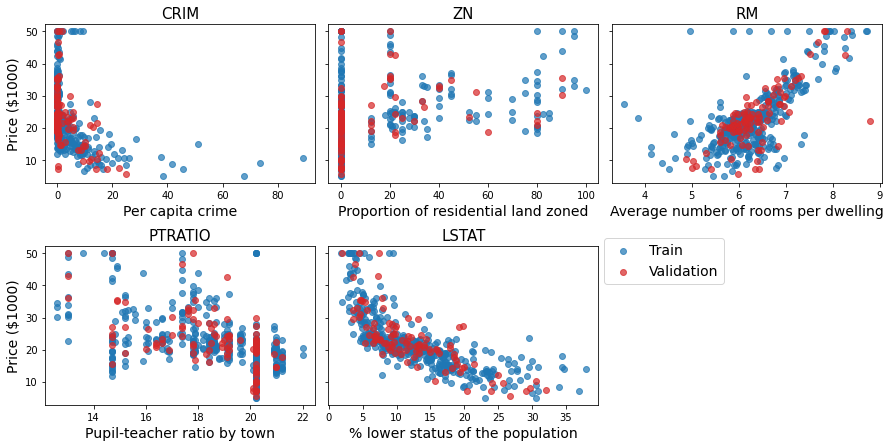

In [ ]:
#@title Raw Data
# Load data
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = boston_housing.load_data()

# Columns to retain
columns_idx   = [0, 1, 5, 10, 12]
columns_names = ['CRIM', 'ZN', 'RM', 'PTRATIO', 'LSTAT']

# Flter columns
x_train_raw = x_train_raw[:, columns_idx]
x_test_raw  = x_test_raw[:, columns_idx]

# Plot raw data
scatter_plot_predictors(columns_names, x_train_raw, y_train_raw, x_test_raw, y_test_raw)

# Remove Outliers
Some outliers in the data are removed, corresponding to rows with $price = 50$ 

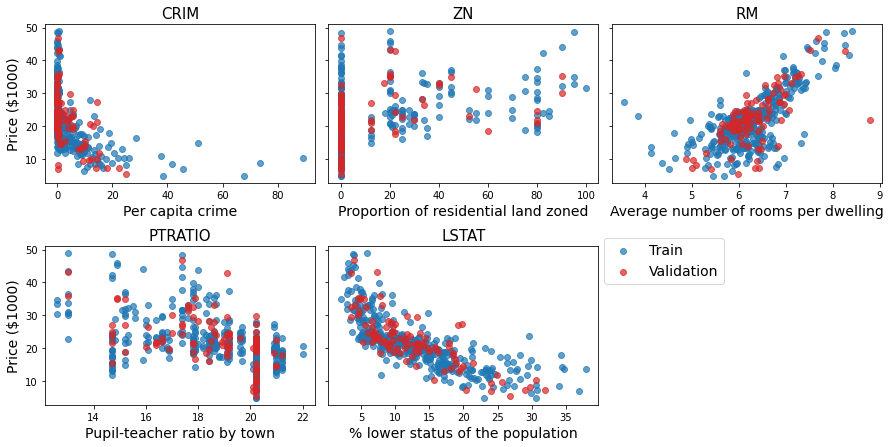

In [ ]:
#@title Remove Outliers
# Remove outliers from the train and test datasets 
x_train, y_train = filter_rows_with_y_equal_val( x_train_raw, y_train_raw, val = 50)
x_test, y_test   = filter_rows_with_y_equal_val( x_test_raw , y_test_raw , val = 50)

# Plot clean data
scatter_plot_predictors(columns_names, x_train, y_train, x_test, y_test)

# Data Normalization
Finally, data is normalized to $0 - 1 $ range

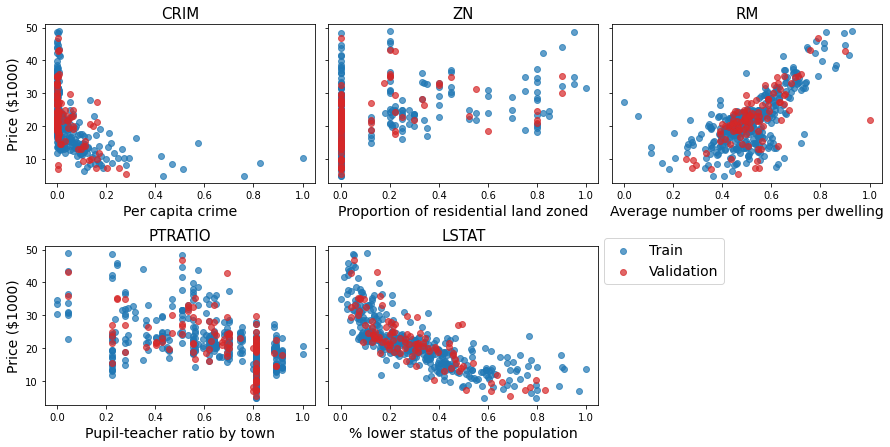

In [ ]:
#@title Scaled Data 
# scaler = preprocessing.StandardScaler().fit(np.vstack([x_train, x_test]))
scaler = preprocessing.MinMaxScaler().fit(np.vstack([x_train, x_test]))

sc_x_train = scaler.transform(x_train)
sc_x_test = scaler.transform(x_test)

# Plot clean data
scatter_plot_predictors(columns_names, sc_x_train, y_train, sc_x_test, y_test)

# Hyperparameter Tuning
Different combinations of model architectures (*number of hidden layers and size*), *learning rates* and *batch sizes* are fitted to explore the effect of each hyperparameter on the loss curves 

In [ ]:
#@title Generate a DataFrame with different model configurations
# grid params
n_layer_list     = [1, 2, 3]
n_neurons_list   = [2, 4, 8]
learn_rate_list  = [0.1, 0.01, 0.001]
batch_size       = 5 # This must be a unique value

# generates a dataframe with the history of each combination of parameters 
models_DF = run_model_grid(n_layer_list, n_neurons_list, learn_rate_list, batch_size_single_value = batch_size)

models_DF.head()

Fitting model 1 with 1 layers, 2 neurons and learning rate of 0.1
Fitting model 2 with 1 layers, 2 neurons and learning rate of 0.01
Fitting model 3 with 1 layers, 2 neurons and learning rate of 0.001
Fitting model 4 with 1 layers, 4 neurons and learning rate of 0.1
Fitting model 5 with 1 layers, 4 neurons and learning rate of 0.01
Fitting model 6 with 1 layers, 4 neurons and learning rate of 0.001
Fitting model 7 with 1 layers, 8 neurons and learning rate of 0.1
Fitting model 8 with 1 layers, 8 neurons and learning rate of 0.01
Fitting model 9 with 1 layers, 8 neurons and learning rate of 0.001
Fitting model 10 with 2 layers, 2 neurons and learning rate of 0.1
Fitting model 11 with 2 layers, 2 neurons and learning rate of 0.01
Fitting model 12 with 2 layers, 2 neurons and learning rate of 0.001
Fitting model 13 with 2 layers, 4 neurons and learning rate of 0.1
Fitting model 14 with 2 layers, 4 neurons and learning rate of 0.01
Fitting model 15 with 2 layers, 4 neurons and learning rat

,History,n_layers,n_units,learn_rate
0,<keras.callbacks.History object at 0x7f6cbb060...,1,2,0.1
1,<keras.callbacks.History object at 0x7f6cb8676...,1,2,0.01
2,<keras.callbacks.History object at 0x7f6cb6c31...,1,2,0.001
3,<keras.callbacks.History object at 0x7f6cb6c31...,1,4,0.1
4,<keras.callbacks.History object at 0x7f6cb6a9e...,1,4,0.01


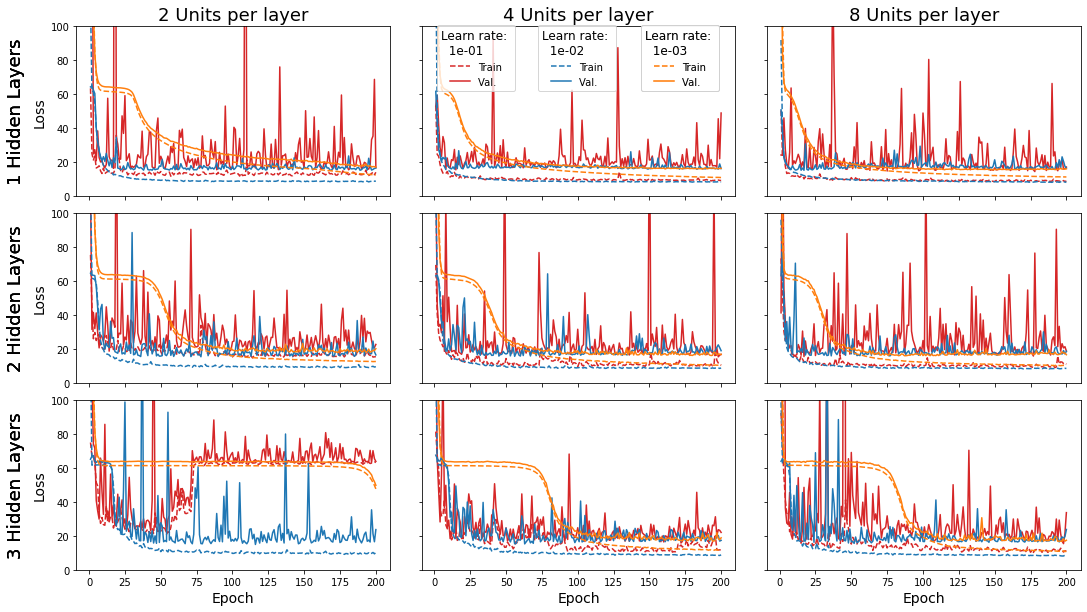

In [ ]:
#@title Display loss curves
plot_model_grid(models_DF, figsize = (18, 10), **{'ylim': (0, 100)})

# Cross-Scatter plot for the optimal model 

In [ ]:
#@title Optimized Model (1 hidden layer, 4 neurons per layer, 0.01 learning rate and batch size of 5)
n_layers = 1
n_neurons = 4
learn_rat = 0.01

model = get_model(n_layers, n_neurons, learn_rat)
history = model.fit(sc_x_train, y_train, batch_size = 5, epochs = 200, validation_data=(sc_x_test, y_test), verbose = 0)

4/4 [==============================] - 0s 4ms/step
R^2:  0.7471202460423311


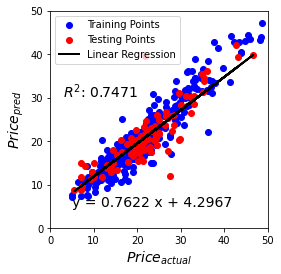

In [ ]:
#@title Cross-Scatter Plot with Linear Regression Line

yhat_train = model.predict(sc_x_train)
yhat_test = model.predict(sc_x_test)

# Cross-Scatter Plot with Linear Regression Line
plt.figure(2)
plt.scatter(y_train, yhat_train, color = 'blue')
plt.scatter(y_test, yhat_test, color = 'red')

m, b = np.polyfit(y_test, yhat_test, 1)

coefficient_of_dermination = r2_score(y_test, yhat_test)
print("R^2: ", coefficient_of_dermination)

plt.plot(y_test, m*y_test+b, color='black', linewidth=2)
plt.text(5, 5, 'y = ' + str(round(m[0],4)) + ' x + '+ str(round(b[0],4)), size=14);
plt.text(3,30, '$R^{2}$: ' + str(round((coefficient_of_dermination),4)), size = 14);

plt.legend(['Training Points','Testing Points','Linear Regression'], loc='upper left')
plt.xlabel('$Price_{actual}$', fontsize = 14)
plt.ylabel('$Price_{pred}$', fontsize = 14)
plt.xlim(0,50)
plt.ylim(0,50)
plt.gca().set_aspect('equal')